# Creating a Deep Progression Chart with Python

<br>

# Libraries

In [1]:
# Data Handling and Analysis
import time
import random
import numpy as np
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import matplotlib.patches as patches
import matplotlib.image as image
from highlight_text import ax_text, fig_text

# Data Scraping
import json
import requests

# Football Pitch Visualisation
from mplsoccer import Pitch, VerticalPitch, add_image

# Miscellaneous
from tqdm.notebook import tqdm

# Filtering out warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

<br> 

# Extracting Data from a Single Game


## Scraping the Data


In [2]:
match_id = '3775648'
event_base_url = 'https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{}.json'
url = event_base_url.format(match_id)

response = requests.get(url=url)

match_dict = json.loads(response.text)

In [3]:
teams = pd.DataFrame(
    {
        'Home': match_dict[0]['team']['name'],
        'Away': match_dict[1]['team']['name']
    },
    index=['Team'])

teams

,Home,Away
Team,Aston Villa,Arsenal WFC


In [4]:
df = pd.json_normalize(match_dict, sep='_')
df['count'] = 1

print('The DataFrame contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
print('First five rows:')
df.head()

The DataFrame contains 3812 rows and 120 columns.
First five rows:


,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,substitution_replacement_name,block_deflection,dribble_nutmeg,shot_one_on_one,shot_open_goal,foul_committed_card_id,foul_committed_card_name,50_50_outcome_id,50_50_outcome_name,count
0,3ae5d153-60b6-4fb0-a4c3-7406eb19134b,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,dd387270-fb96-4574-aba5-4817cd6de379,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1cae007e-b10b-4959-be1f-5b595313b72c,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,02403d23-9d60-4754-a1d7-7143ce0cffd7,4,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,d062f895-1e3c-4fff-9937-fa3c81408bf7,5,1,00:00:00.340,0,0,2,0.311672,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
df.groupby(['team_name']).count()['count'].to_frame(name='Events')

,Events
team_name,
Arsenal WFC,2679
Aston Villa,1133


In [6]:
goals = df[df['shot_outcome_name'] == 'Goal'][['team_name', 'player_name', 'minute']]
goals = goals.sort_values(by='minute')

goals.index = np.arange(1, len(goals) + 1)
goals.index.name = 'Goal'
goals.columns = ['Team', 'Player', 'Minute']

goals

,Team,Player,Minute
Goal,,,
1,Arsenal WFC,Vivianne Miedema,57
2,Arsenal WFC,Jordan Nobbs,66
3,Arsenal WFC,Katie McCabe,72
4,Arsenal WFC,Lisa Evans,87


<br>

## Extracting Deep Progression Information

In [7]:
df['type_name'].value_counts().to_frame(name='Count')

,Count
Pass,1030
Ball Receipt*,999
Carry,937
Pressure,286
Ball Recovery,106
Duel,69
Dribble,49
Interception,48
Block,44
Goal Keeper,39




<br>

### (Starting) Location



In [8]:
print("NaN values in 'location':", df['location'].isnull().sum())

NaN values in 'location': 17


In [9]:
df = df[df['location'].notnull()].reset_index(drop=True)

In [10]:
df[['x', 'y']] = pd.DataFrame(df['location'].values.tolist(), index=df.index)

df[['location', 'x', 'y']].head()

,location,x,y
0,"[61.0, 40.1]",61.0,40.1
1,"[62.0, 42.3]",62.0,42.3
2,"[62.0, 42.3]",62.0,42.3
3,"[59.3, 40.8]",59.3,40.8
4,"[42.0, 39.9]",42.0,39.9




<br>

### End Location - Passes

In [11]:
pass_df = df[df['pass_end_location'].notnull()]

pass_df[['pass_end_x', 'pass_end_y']] = pd.DataFrame(pass_df['pass_end_location'].values.tolist(),
                                                     index=pass_df.index)

<br>

### End Location - Carries

In [12]:
carry_df = df[df['carry_end_location'].notnull()]

carry_df[['carry_end_x', 'carry_end_y']] = pd.DataFrame(carry_df['carry_end_location'].values.tolist(),
                                                        index=carry_df.index)

<br>

### Merging the two DataFrames

In [13]:
df_tot = pass_df.append(carry_df, sort=False)

cols = ['x', 'y', 'pass_end_x', 'pass_end_y', 'carry_end_x', 'carry_end_y']
df_tot[cols].head()

,x,y,pass_end_x,pass_end_y,carry_end_x,carry_end_y
0,61.0,40.1,62.0,42.3,NaN,NaN
3,59.3,40.8,42.0,39.9,NaN,NaN
6,42.9,41.1,40.3,22.7,NaN,NaN
9,40.3,22.7,53.3,26.8,NaN,NaN
13,57.2,19.6,62.7,4.6,NaN,NaN


In [14]:
print('Number of rows:', df_tot.shape[0])

Number of rows: 1967


<br>

### Calculating Distance to Goal

In [15]:
df_tot['initial_distance'] = np.sqrt(((120 - df_tot['x'])**2) +
                                     ((40 - df_tot['y'])**2))

df_tot['final_distance_pass'] = np.sqrt(((120 - df_tot['pass_end_x'])**2) +
                                        ((40 - df_tot['pass_end_y'])**2))

df_tot['final_distance_carry'] = np.sqrt(((120 - df_tot['carry_end_x'])**2) +
                                         ((40 - df_tot['carry_end_y'])**2))

In [16]:
df_tot['is_deep_completion'] = np.where(
    ((df_tot['final_distance_pass'] <= 21.87) & (df_tot['initial_distance'] >= 21.87) |
     ((df_tot['final_distance_carry'] <= 21.87) & (df_tot['initial_distance'] >= 21.87))),
    True, False)

In [17]:
deep_completion_no = df_tot[df_tot['is_deep_completion'] == True].shape[0]
print('Number of deep completions: ', deep_completion_no)

Number of deep completions:  70


In [18]:
deep_completion_df = df_tot.loc[
    (df_tot['play_pattern_name'] != 'From Corner')
    & (((df_tot['is_deep_completion'] == True)
        & (df_tot['pass_outcome_name'] != 'Incomplete')))]

deep_completion_no=deep_completion_df.shape[0]
print('Number of deep completions: ', deep_completion_no)

Number of deep completions:  28


In [19]:
deep_completion_df.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,x,y,pass_end_x,pass_end_y,carry_end_x,carry_end_y,initial_distance,final_distance_pass,final_distance_carry,is_deep_completion
748,4d8ec3d1-e0a7-468b-941b-d2f9c49b3246,753,1,00:17:49.485,17,49,31,1.142011,30,Pass,...,90.7,32.4,107.6,27.8,NaN,NaN,30.269622,17.395402,NaN,True
754,92ee93fa-975e-4c62-bdcf-68aae3c12f91,759,1,00:17:52.905,17,52,31,0.976357,30,Pass,...,104.7,12.8,103.5,27.1,NaN,NaN,31.207852,20.944212,NaN,True
841,b68774bb-e301-4876-939d-4c2b37ec94eb,846,1,00:19:31.721,19,31,34,1.682703,30,Pass,...,110.7,0.1,104.7,27.8,NaN,NaN,40.969501,19.568597,NaN,True
856,17f634ac-b65d-4320-9f86-83732f4d88bd,861,1,00:19:44.863,19,44,34,1.048745,30,Pass,...,85.4,56.0,98.9,45.4,NaN,NaN,38.120336,21.780037,NaN,True
1178,7add0ac5-fac8-4571-8612-c63ac1017502,1183,1,00:27:43.180,27,43,48,1.737165,30,Pass,...,116.0,0.1,116.5,26.8,NaN,NaN,40.100000,13.656134,NaN,True


<br>

## Turning Code into a Function

In [20]:
def get_match_df(match_id):
    url = event_base_url.format(match_id)
    response = requests.get(url=url)

    match_dict = json.loads(response.text)
    
    return pd.json_normalize(match_dict, sep='_')

In [21]:
def get_deep_completions_per_game(match_id):

    # Step 01: Get the data
    df = get_match_df(match_id)
    df['count'] = 1

    # Step 02: Remove NaNs in location and extract `x` and `y` coordinates
    df = df[df['location'].notnull()].reset_index(drop=True)
    df[['x', 'y']] = pd.DataFrame(df['location'].values.tolist(), index=df.index)

    # Step 03: Remove NaNs in 'pass_end_location' and extract coordinated
    pass_df = df[df['pass_end_location'].notnull()]
    pass_df[['pass_end_x', 'pass_end_y']] = pd.DataFrame(pass_df['pass_end_location'].values.tolist(),
                                                         index=pass_df.index)

    # Step 04: Repeat for 'carry_end_location'
    carry_df = df[df['carry_end_location'].notnull()]
    carry_df[['carry_end_x', 'carry_end_y']] = pd.DataFrame(carry_df['carry_end_location'].values.tolist(),
                                                            index=carry_df.index)

    # Step 05: Merge the two dataframes
    df_tot = pass_df.append(carry_df, sort=False)

    # Step 06: Calculate initial and final distance for all passes and carries
    df_tot['initial_distance'] = np.sqrt(((120 - df_tot['x'])**2) +
                                         ((40 - df_tot['y'])**2))

    df_tot['final_distance_pass'] = np.sqrt(((120 - df_tot['pass_end_x'])**2) +
                                            ((40 - df_tot['pass_end_y'])**2))

    df_tot['final_distance_carry'] = np.sqrt((
        (120 - df_tot['carry_end_x'])**2) + ((40 - df_tot['carry_end_y'])**2))

    # Step 07: Filter our all events that are not deep completions
    df_tot['is_deep_completion'] = np.where(
        ((df_tot['final_distance_pass'] <= 21.87) & (df_tot['initial_distance'] >= 21.87) |
         ((df_tot['final_distance_carry'] <= 21.87) & (df_tot['initial_distance'] >= 21.87))),
        True, False)

    # Step 08: Exclude actions from corners and incomplete actions
    deep_completion_df = df_tot.loc[
        (df_tot['play_pattern_name'] != 'From Corner')
        & (((df_tot['is_deep_completion'] == True)
            & (df_tot['pass_outcome_name'] != 'Incomplete')))]

    return deep_completion_df

In [22]:
deep_completion_df_2 = get_deep_completions_per_game(match_id)
deep_completion_df_2.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,x,y,pass_end_x,pass_end_y,carry_end_x,carry_end_y,initial_distance,final_distance_pass,final_distance_carry,is_deep_completion
748,4d8ec3d1-e0a7-468b-941b-d2f9c49b3246,753,1,00:17:49.485,17,49,31,1.142011,30,Pass,...,90.7,32.4,107.6,27.8,NaN,NaN,30.269622,17.395402,NaN,True
754,92ee93fa-975e-4c62-bdcf-68aae3c12f91,759,1,00:17:52.905,17,52,31,0.976357,30,Pass,...,104.7,12.8,103.5,27.1,NaN,NaN,31.207852,20.944212,NaN,True
841,b68774bb-e301-4876-939d-4c2b37ec94eb,846,1,00:19:31.721,19,31,34,1.682703,30,Pass,...,110.7,0.1,104.7,27.8,NaN,NaN,40.969501,19.568597,NaN,True
856,17f634ac-b65d-4320-9f86-83732f4d88bd,861,1,00:19:44.863,19,44,34,1.048745,30,Pass,...,85.4,56.0,98.9,45.4,NaN,NaN,38.120336,21.780037,NaN,True
1178,7add0ac5-fac8-4571-8612-c63ac1017502,1183,1,00:27:43.180,27,43,48,1.737165,30,Pass,...,116.0,0.1,116.5,26.8,NaN,NaN,40.100000,13.656134,NaN,True


In [23]:
deep_completion_df.equals(deep_completion_df_2)

True

<br>

# Extracting Data from a Multiple Games

In [24]:
competition_id = 37
season_id = 90
competition_name = 'FA WSL 20-21'

In [25]:
def get_comp_match_ids(competition_id, season_id):
    '''Returns the ids for all matches taking place during the specified season of the competition.'''
    comp_base_url = 'https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/{}/{}.json'
    url = comp_base_url.format(competition_id, season_id)

    matches = requests.get(url=url).json()
    match_ids = [m['match_id'] for m in matches]
    print('Number of games in this competition:', len(match_ids))

    return match_ids

In [26]:
def get_deep_completions_per_comp(competition_id, season_id, df_tot):
    '''Returns a DataFrame with all deep completions taking place during the specified season of the competition.'''
    match_ids = get_comp_match_ids(competition_id, season_id)

    for match_id in tqdm(match_ids):

        df_tot = df_tot.append(get_deep_completions_per_game(match_id))

        # Add a random delay time between 0.1 and 1 s
        time.sleep(random.uniform(0.1, 1))

    return df_tot.reset_index(drop=True)

In [27]:
df_tot = get_deep_completions_per_comp(competition_id,
                                       season_id,
                                       df_tot=pd.DataFrame())

Number of games in this competition: 131


In [28]:
print('Total number of deep completions in the competition:', df_tot.shape[0])

Total number of deep completions in the competition: 3515


<br>

# Data Visualisation

In [35]:
pitch_color = '#0f253a'
face_color = pitch_color
line_color = 'white'
zone_color = 'tab:orange'
pass_color = 'tab:blue'
carry_color = 'tab:red'

radius = 21.87  # radius of the penalty box to draw the arc

plt.rcParams['text.color'] = 'white'
plt.rcParams['font.family'] = 'Century Gothic'
plt.rcParams['font.weight'] = 'bold'

highlight_textprops =\
    [{'color': pass_color, 'fontweight': 'bold'},
     {'color': carry_color, 'fontweight': 'bold'},
     {'color': zone_color, 'fontweight': 'normal'}
    ]

subtitle = 'A <completed pass> or <carry> that ends in the <highlighted zone> | {}'.format(
    competition_name)

In [30]:
def create_pitch_axes(nrows,
                      ncols,
                      figheight=9,
                      title_height=0.13,
                      grid_height=0.78,
                      space=0.05):
    '''Creates a pitch object and adds the highlighted area.'''

    ### 01 - Create the pitch object ###
    pitch = VerticalPitch(
        pitch_type='statsbomb',
        half=True,
        pitch_color=pitch_color,
        line_color=line_color,
        linewidth=2,
        spot_scale=0.0,  # remove centre and penalty spots
        pad_bottom=0.5,
        pad_top=0.1,
        tight_layout=True,
        constrained_layout=True)

    fig, ax = pitch.grid(figheight=figheight,
                         nrows=nrows,
                         ncols=ncols,
                         endnote_height=0.0,
                         endnote_space=0.0,
                         grid_height=grid_height,
                         title_height=title_height,
                         space=space,
                         axis=False)
    fig.set_facecolor(pitch_color)

    ### 02 - Add highlighed area ###
    for i in np.arange(0, ncols * nrows):
        circle = patches.Circle([40, 120],
                                radius=radius,
                                facecolor='none',
                                edgecolor=zone_color,
                                linewidth=3,
                                linestyle='--')

        if ncols > 1 or nrows > 1:
            ax['pitch'].flatten()[i].add_patch(circle)
        else:
            ax['pitch'].add_patch(circle)

    return fig, ax, pitch

In [31]:
def add_title(fig, title='Deep Progression Chart', fontsize=32):
    fig.suptitle(title, fontsize=fontsize, fontweight='bold', y=0.995)


def add_subtitle(subtitle, x=0.500, y=0.915, fontsize=20):
    fig_text(s=subtitle,
             x=x,
             y=y,
             size=fontsize,
             fontweight='normal',
             highlight_textprops=highlight_textprops,
             ha='center',
             va='center')


def add_acknowledgements(fontsize=20, lg_left=0.70, lg_bottom=-0.055, lg_width=0.20, lg_height=0.15):
    ### 01 - Add acknowledgements ###
    fig_text(s='Created by: Konstantinos Orfanakis | Data: ',
             x=0.690,
             y=0.016,
             size=fontsize,
             fontweight='normal',
             ha='right',
             va='center')

    ### 02 - Add Statsbomb's logo ###
    ax_image = add_image(image.imread('Images\StatsBomb_Logo.png'),
                         fig,
                         left=lg_left,
                         bottom=lg_bottom,
                         width=lg_width,
                         height=lg_height)

In [32]:
def add_pitch_title(ax, selection, pitch_title=20):
    ### 01 - Add pitch title ###
    ax.set_title(str(selection),
                 size=pitch_title,
                 fontweight='bold',
                 pad=10,
                 bbox=dict(facecolor=pitch_color,
                           edgecolor=line_color,
                           linewidth=1,
                           pad=0.30,
                           boxstyle='round'))

In [33]:
def add_deep_completions(df, col, selection, ax, num_size=32):

    ### 01 - Calculate the number of deep completions ###
    df_sel = df[df[col] == selection]

    num_passes = df_sel[df_sel['final_distance_pass'].notnull()].shape[0]
    num_carries = df_sel[df_sel['final_distance_carry'].notnull()].shape[0]
    num_total = num_passes + num_carries

    ### 02 - Add number of deep passes + carries ###
    for x, number, text, ha, color in zip([25, 40, 55],
                                          [num_passes, num_total, num_carries],
                                          ['{} passes', '{}', '{} carries'],
                                          ['right', 'center', 'left'],
                                          [pass_color, 'white', carry_color]):
        ax.text(x=x,
                y=63,
                s=text.format(number),
                color=color,
                size=num_size,
                ha=ha,
                va='center')

    ### 03 - Add deep completions ###
    for dc_type, color in zip(['pass', 'carry'], [pass_color, carry_color]):

        pitch.lines(df_sel['x'],
                    df_sel['y'],
                    df_sel['{}_end_x'.format(dc_type)],
                    df_sel['{}_end_y'.format(dc_type)],
                    color=color,
                    alpha=0.7,
                    lw=2,
                    comet=True,
                    ax=ax)

        pitch.scatter(df_sel['{}_end_x'.format(dc_type)],
                      df_sel['{}_end_y'.format(dc_type)],
                      color=pitch_color,
                      edgecolors=color,
                      alpha=0.9,
                      linewidths=5,
                      s=3,
                      ax=ax)

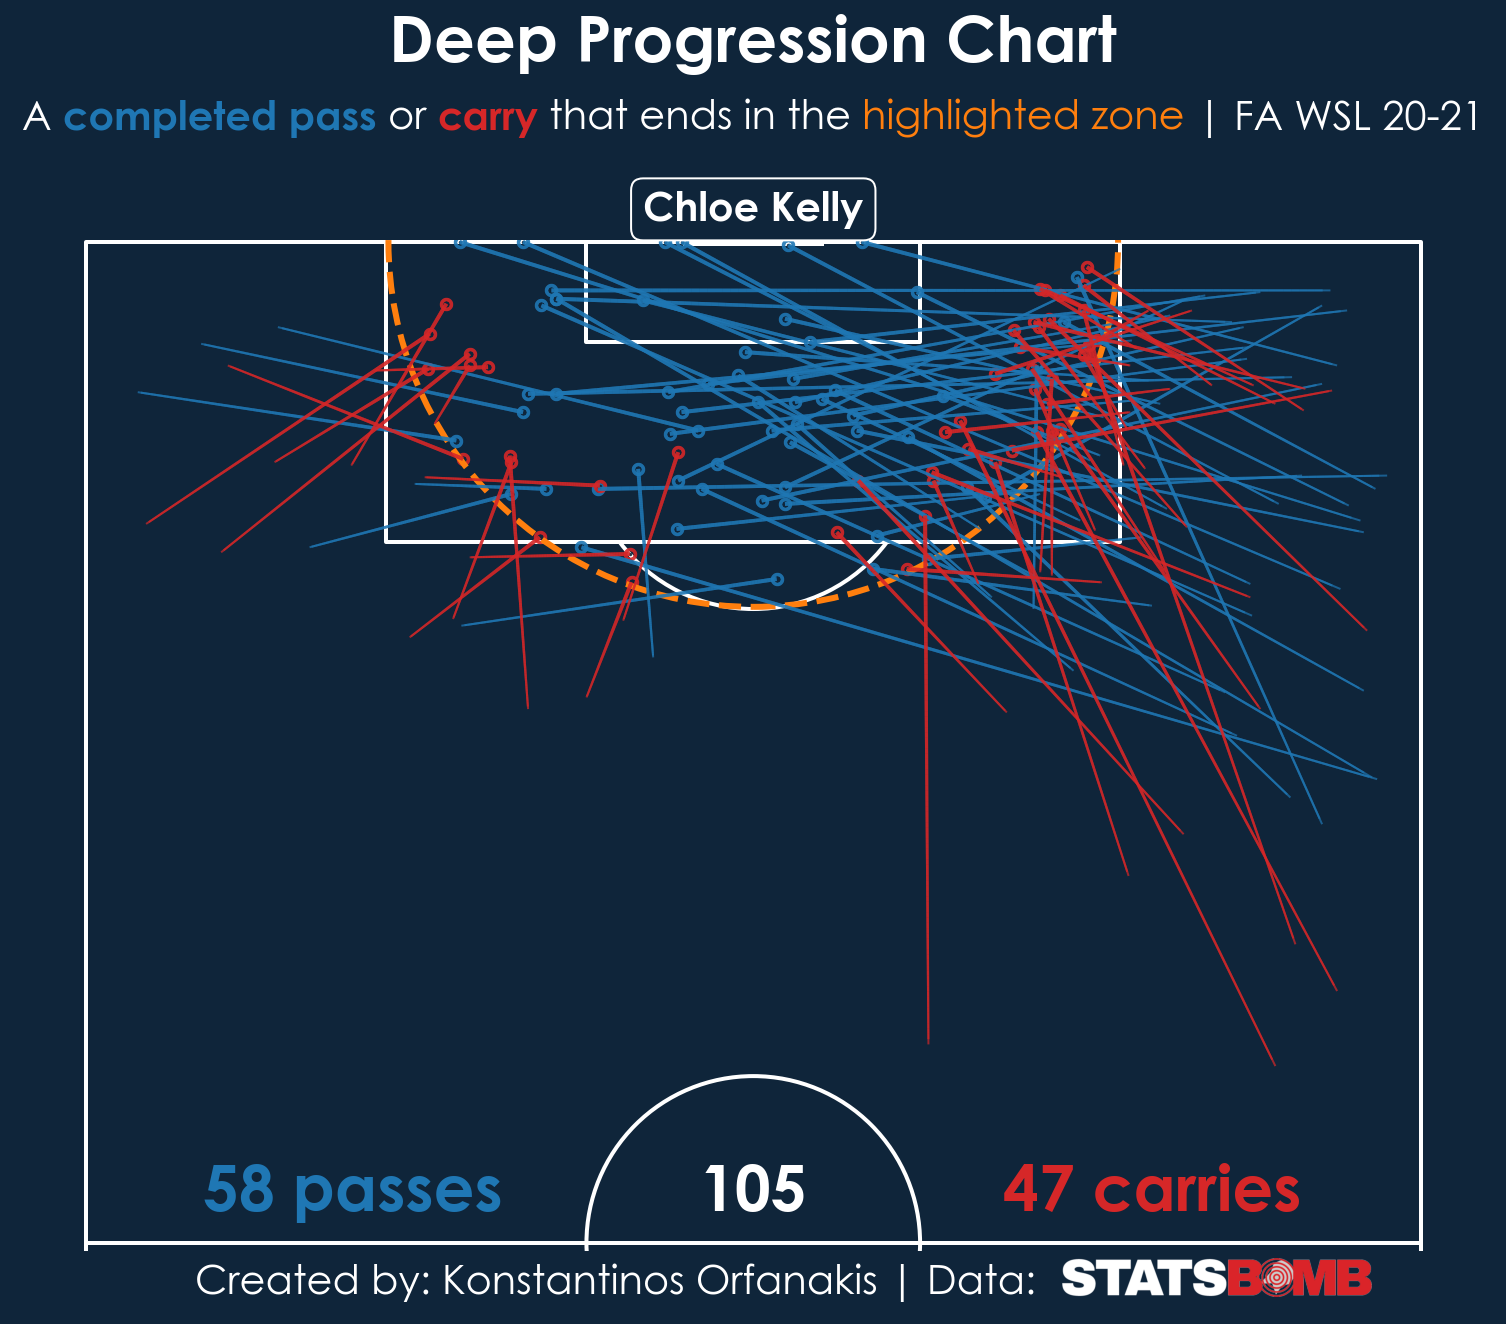

In [36]:
col = 'player_name'
selection = 'Chloe Kelly'

fig, ax, pitch = create_pitch_axes(nrows=1, ncols=1)
add_title(fig)
add_subtitle(subtitle)
add_pitch_title(ax['pitch'], selection, pitch_title=20)
add_deep_completions(df_tot, col, selection, ax['pitch'], num_size=32)
add_acknowledgements(fontsize=20)

# plt.savefig('Images\Figure01-{}.png'.format(selection))

<br>

<br>

---

<br>

<br>

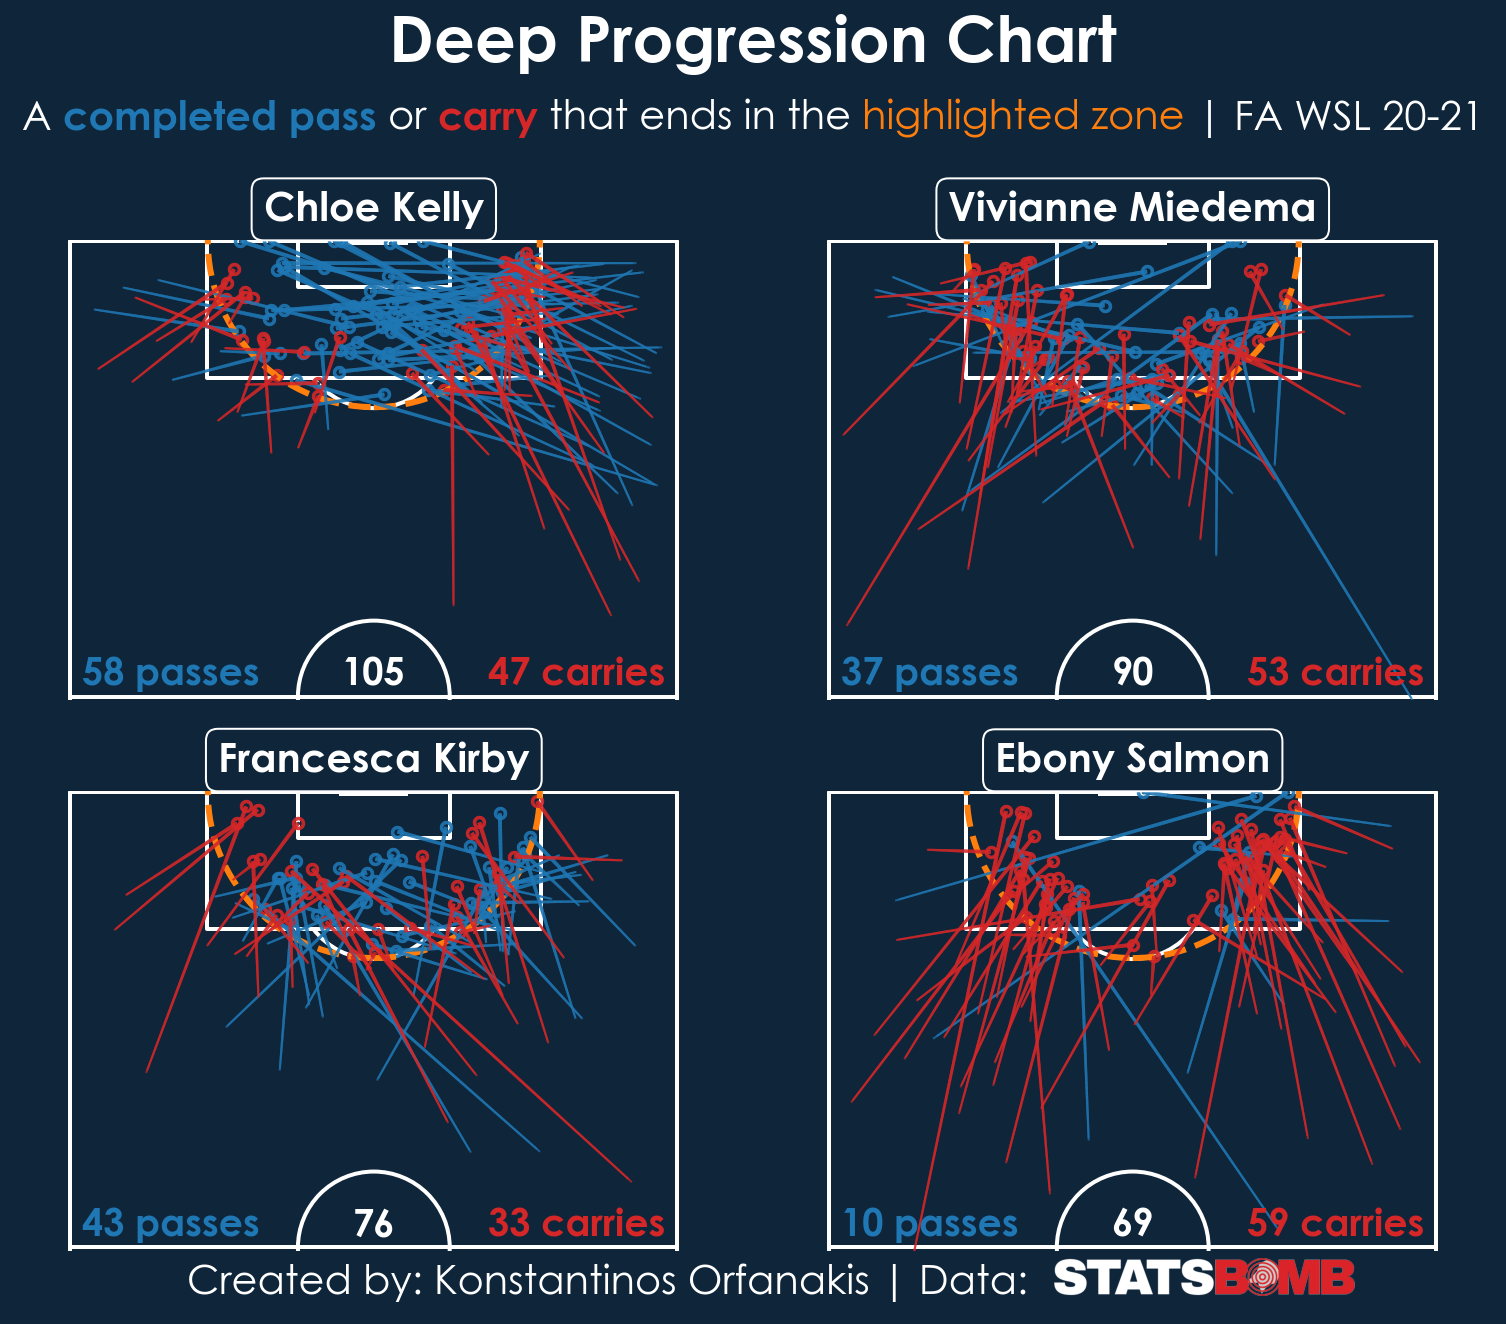

In [37]:
players = list(df_tot['player_name'].value_counts().index[0:4])
col = 'player_name'

nrows, ncols = 2, 2

fig, ax, pitch = create_pitch_axes(nrows=nrows, ncols=ncols, space=0.09)
add_title(fig)
add_subtitle(subtitle)

for i, selection in enumerate(players):
    if ncols > 1 or nrows > 1:
        ax_pitch = ax['pitch'].flatten()[i]
    else:
        ax_pitch = ax['pitch']
        
    add_pitch_title(ax_pitch, selection, pitch_title=20)
    add_deep_completions(df_tot, col, selection, ax_pitch, num_size=19)
    
add_acknowledgements(fontsize=20)

<br>

---

<br>

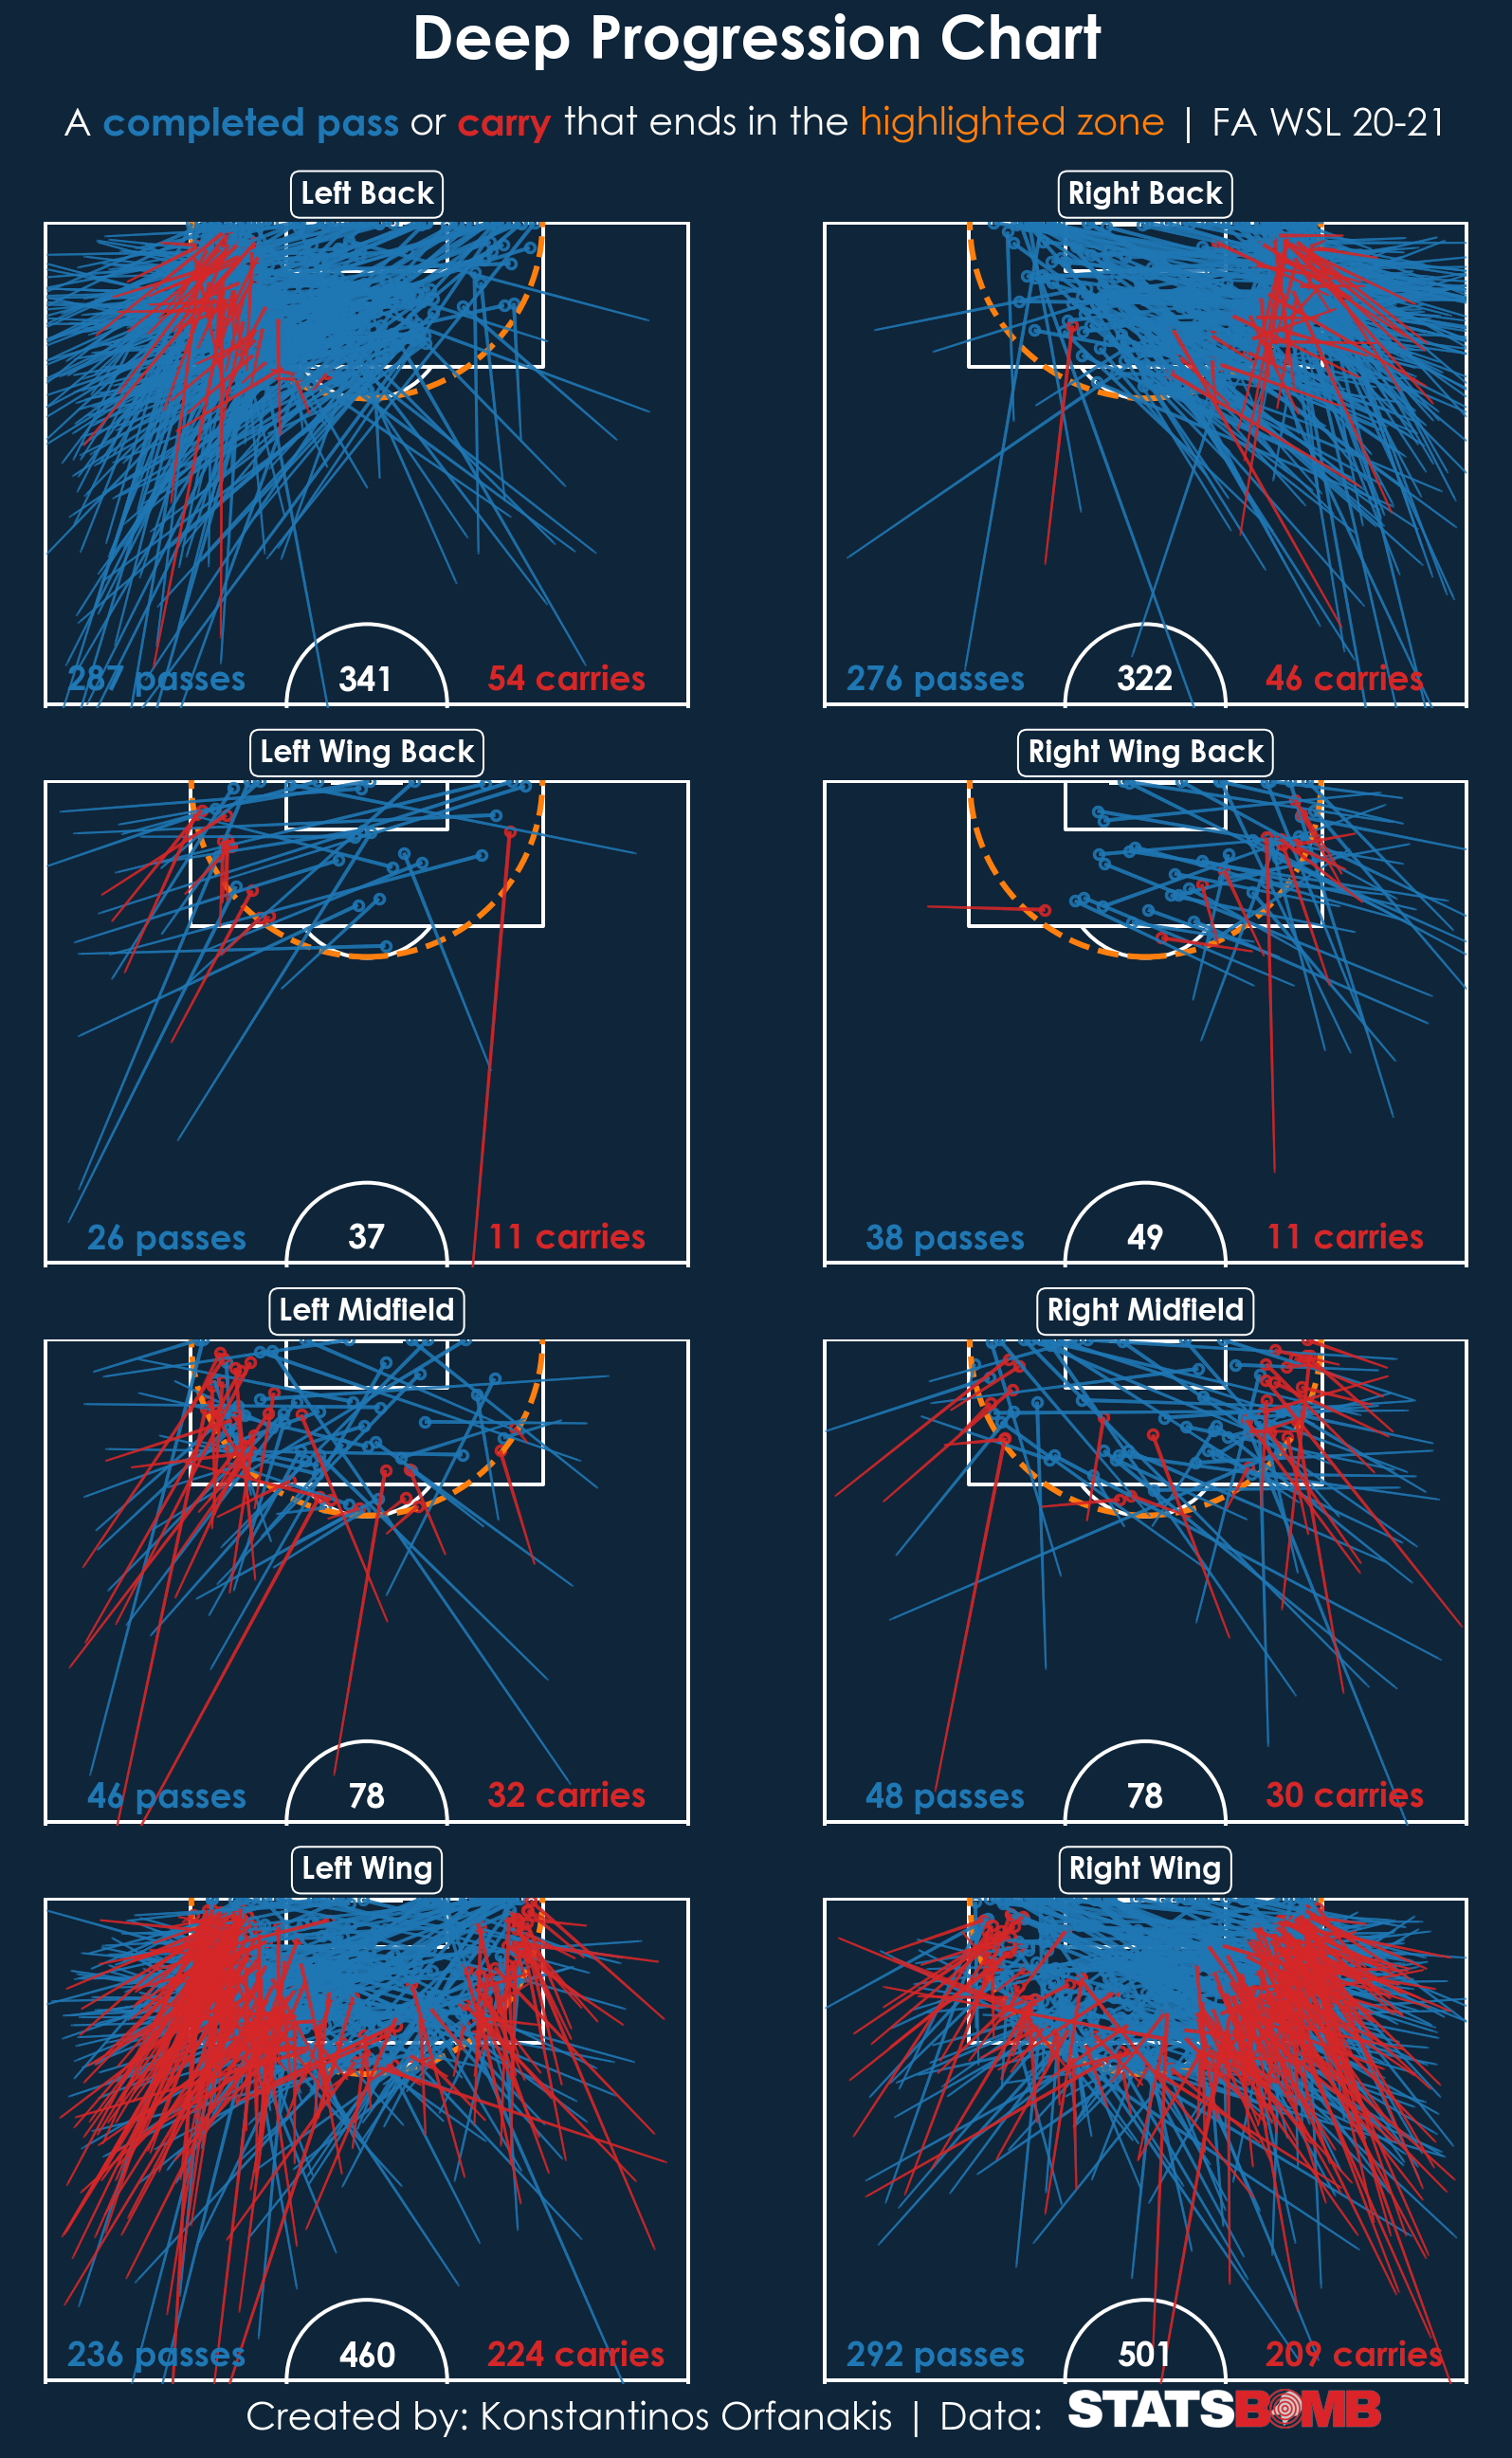

In [38]:
positions = [
    'Left Back', 'Right Back', 'Left Wing Back', 'Right Wing Back',
    'Left Midfield', 'Right Midfield', 'Left Wing', 'Right Wing'
]
col = 'position_name'

nrows, ncols = 4, 2

fig, ax, pitch = create_pitch_axes(nrows=nrows,
                                   ncols=ncols,
                                   figheight=18,
                                   title_height=0.05,
                                   grid_height=0.88,
                                   space=0.1)
add_title(fig)
add_subtitle(subtitle, y = 0.95)

for i, selection in enumerate(positions):
    if ncols > 1 or nrows > 1:
        ax_pitch = ax['pitch'].flatten()[i]
    else:
        ax_pitch = ax['pitch']
        
    add_pitch_title(ax_pitch, selection, pitch_title=16)
    add_deep_completions(df_tot, col, selection, ax_pitch, num_size=18)
    
add_acknowledgements(fontsize=20)

<br>

---

<br>

<br>

---